Imports

In [1]:
from models import ff_eucl
import ff_hyp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
from torch.utils.tensorboard import SummaryWriter
torch.cuda.is_available()

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Data Transformation

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [4]:
train_set = datasets.KMNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
test_set = datasets.KMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

size = len(train_set)
print(size)

train_data, val_data = torch.utils.data.random_split(train_set, [int(size-size*0.2), int(size*0.2)])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle= True, num_workers=6, pin_memory=True)

60000


C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the model

Hyperparameters

Optimizer

In [5]:

# time0 = time()

# epochs = 10
# for e in range(epochs):
#     running_loss = 0
#     for images, labels in trainloader:
#         images, labels = images.to(device), labels.to(device)
#         # Flatten MNIST images into a 784 long vector
#         images = 0.0357*images.view(images.shape[0], -1)
    
#         # Training pass
#         optimizer.zero_grad()
        
#         output = model(images)
#         loss = criterion(output, labels)
        
#         #backpropagation
#         loss.backward()
        
#         #Weight optimization
#         optimizer.step()
        
#         running_loss += loss.item()
#     else:
#         print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
# print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [6]:
### Single prediction function
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

### Training function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_correct = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        #images = ball.projx(images.view(images.shape[0], -1))
        # Training pass
        optimizer.zero_grad()
        # for param in model.parameters():
        #     param.grad = None

        output = model(images)
        loss = criterion(output, labels)  
        train_loss += loss.item()
        total_correct += get_num_correct(output, labels)
        #backpropagation
        loss.backward()      
        #Weight optimization
        optimizer.step()  

    return train_loss/len(dataloader.dataset), total_correct

### Validation function
def val_epoch(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for  images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            #images = ball.projx(images.view(images.shape[0], -1))
            output = model(images)
            loss = criterion(output, labels)  
            val_loss += loss.item()
            val_correct += get_num_correct(output, labels)
    
    return val_loss/len(dataloader.dataset), val_correct



### Model evaluation
def model_eval(model, epochs, trainloader, valloader, optimizer, criterion):
    tb = SummaryWriter()
    t_loss = []
    v_loss = []
    t_accuracy = []
    v_accuracy = []
    epoch_values = []
    for epoch in range(epochs):
        train_loss, total_correct = train_epoch(model, trainloader, optimizer, criterion) 
        t_loss.append(train_loss)
        t_accuracy.append(total_correct/len(train_data))
        val_loss, val_correct = val_epoch(model, valloader, criterion)
        v_loss.append(val_loss)
        v_accuracy.append(val_correct/len(val_data))
        epoch_values.append(epoch)
        
        tb.add_scalar("Training Loss", train_loss, epoch)
        tb.add_scalar("Validation Loss", val_loss, epoch)
        tb.add_scalar("Training Accuracy", total_correct/len(train_data), epoch)
        tb.add_scalar("Validation Accuracy", val_correct/len(val_data), epoch)
        print("epoch:", epoch, "training loss:",train_loss, "validation loss:", val_loss,
        "training accuracy:", total_correct/len(train_data), "validation accuracy:", val_correct/len(val_data))


    return t_loss, v_loss, t_accuracy, v_accuracy, epoch_values

In [11]:
#model = ff_eucl.EuclFF(784, 512, 256, 10, nn.ReLU())
model = ff_hyp.HypFF(784, 512, 256, 10)
print(model)

epochs = 10
#Hyperparameter tuning
#hparams_tune(epochs)
#Model evaluation
lr=0.01
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.NLLLoss()

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=lr, momentum=0.9)
t_loss ,v_loss, t_accuracy, v_accuracy, epoch_values = model_eval(model, epochs, trainloader, valloader, optimizer, criterion)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(in_features=784, out_features=512, bias=True)
  (fc2): MobLinear(in_features=512, out_features=256, bias=True)
  (fc3): MobLinear(in_features=256, out_features=10, bias=True)
)
epoch: 0 training loss: 0.03291328182071447 validation loss: 0.026630952815214794 training accuracy: 0.36002083333333335 validation accuracy: 0.8051666666666667
epoch: 1 training loss: 0.02431519000728925 validation loss: 0.023628637899955115 training accuracy: 0.895 validation accuracy: 0.9335833333333333
epoch: 2 training loss: 0.023244246922433376 validation loss: 0.023310309847195943 training accuracy: 0.9508541666666667 validation accuracy: 0.9471666666666667
epoch: 3 training loss: 0.02290703105678161 validation loss: 0.0231535447537899 training accuracy: 0.9709583333333334 validation accuracy: 0.9555
epoch: 4 training loss: 0.0227127515176932 validation loss: 0.023107204377651215 training accuracy: 0.9811666666666666 validation accuracy: 0.9550833333333333
epoc

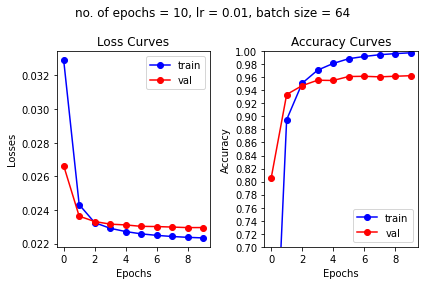

In [13]:
from matplotlib.ticker import FormatStrFormatter

fig , (ax0, ax1) = plt.subplots(1, 2)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax1.set_title('Accuracy Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')
ax1.plot(epoch_values, t_accuracy, 'bo-', label='train')
ax1.plot(epoch_values, v_accuracy, 'ro-', label='val')


#start, end = ax1.get_ylim()
ax1.yaxis.set_ticks(np.arange(0.7, 1.0, 0.02))
ax1.set_ylim(0.7, 1.0)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax0.set_xlabel('Epochs')
ax1.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax1.set_ylabel('Accuracy')
ax0.legend()
ax1.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64'.format(epochs, lr))
fig.tight_layout()

In [9]:
# images, labels = next(iter(valloader))
# #images, labels = images.to(device), labels.to(device)

# img = 0.0357*images[0].view(1, 784)
# img_gpu = img.to(device)
# with torch.no_grad():
#     out = model(img_gpu)

# ps = out.cpu()
# print(ps)
# probab = list(ps.numpy()[0])
# print(probab)
# print("Predicted Digit =", probab.index(max(probab)))
# helper.view_classify(img.view(1, 28, 28), ps)

In [10]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 12000

Model Accuracy = 0.18025


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.